# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 304866551 204118616 ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

In [4]:
#### Your code here ####
def histogram_visualization(data_0, data_1, bins, alpha, title):
    plt.hist(data_0, bins=bins, alpha=alpha, label='y=0')
    plt.hist(data_1, bins=bins, alpha=alpha, label='y=1')
    plt.legend()
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    
def scatter_visualization(data_0, data_1, title):
    plt.scatter(data_0[:, 0], data_0[:, 1], label='y=0')
    plt.scatter(data_1[:, 0], data_1[:, 1], label='y=1')
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

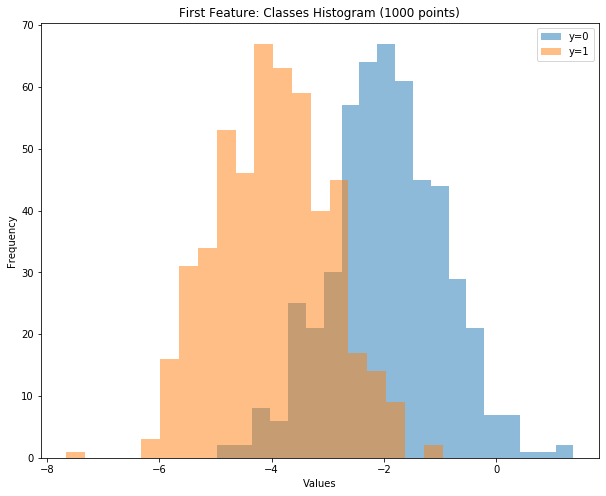

In [5]:
# First Feature: For the first 1000 data points plot a histogram for each class on the same graph
first_feature_training_set_1000 = training_set.head(1000)
first_feature_training_set_1000_0 = first_feature_training_set_1000[first_feature_training_set_1000['y'] == 0]
first_feature_training_set_1000_1 = first_feature_training_set_1000[first_feature_training_set_1000['y'] == 1]

histogram_visualization(first_feature_training_set_1000_0.values[:, 0], first_feature_training_set_1000_1.values[:, 0], 
              bins=20, alpha=0.5, title='First Feature: Classes Histogram (1000 points)')

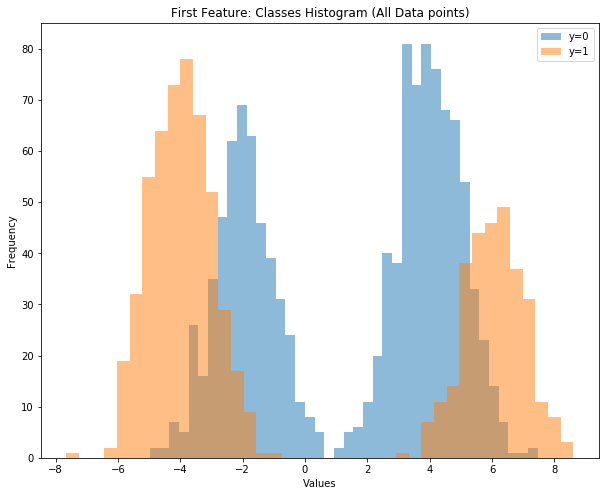

In [6]:
# First Feature: For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5)
first_feature_training_set_all_data = training_set.copy()
first_feature_training_set_all_data_0 = first_feature_training_set_all_data[first_feature_training_set_all_data['y'] == 0]
first_feature_training_set_all_data_1 = first_feature_training_set_all_data[first_feature_training_set_all_data['y'] == 1]

histogram_visualization(first_feature_training_set_all_data_0.values[:, 0], first_feature_training_set_all_data_1.values[:, 0], 
              bins=40, alpha=0.5, title='First Feature: Classes Histogram (All Data points)')

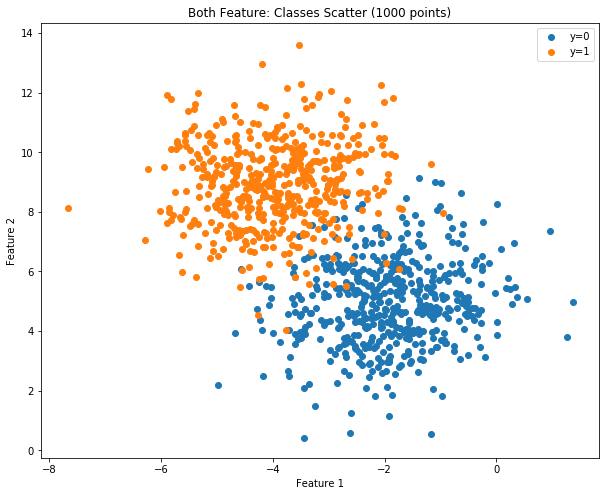

In [7]:
# Both Feature: For the first 1000 data points plot a scatter plot where each class has different color
training_set_1000 = training_set.head(1000)
training_set_1000_0 = training_set_1000[training_set_1000['y'] == 0]
training_set_1000_1 = training_set_1000[training_set_1000['y'] == 1]

scatter_visualization(training_set_1000_0.values[:, :-1], training_set_1000_1.values[:, :-1], 
                      title='Both Feature: Classes Scatter (1000 points)')

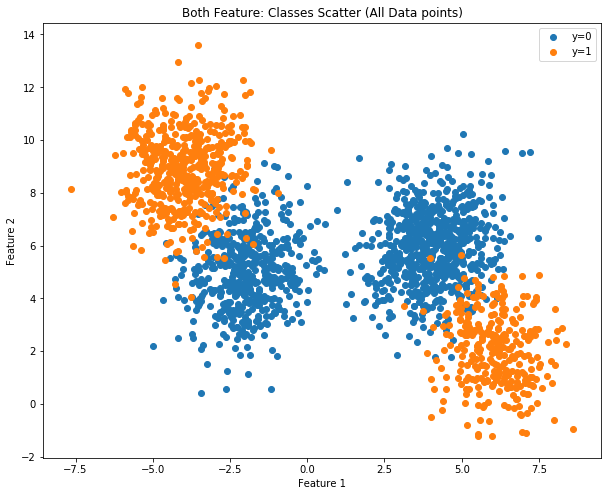

In [8]:
# Both Feature: For all the data points plot a scatter plot where each class has different color
training_set_all_data = training_set.copy()
training_set_all_data_0 = training_set_all_data[training_set_all_data['y'] == 0]
training_set_all_data_1 = training_set_all_data[training_set_all_data['y'] == 1]

scatter_visualization(training_set_all_data_0.values[:, :-1], training_set_all_data_1.values[:, :-1], 
                      title='Both Feature: Classes Scatter (All Data points)')

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [9]:
class LogisticRegressionGD:
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """

    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

        self.theta = None
        self.J_history = []

        # generate seed for random weight
        np.random.seed(self.random_state)

    def fit(self, X, y):
        """
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """

        # get the data shape
        m = X.shape[0]

        # bias trick
        X = np.concatenate([np.ones((m, 1)), X], axis=1)
        y = y.reshape(-1, 1)

        # generate the initial random thetas
        self.theta = (np.random.random(size=X.shape[1])).reshape(1, -1)

        # train the data
        for i in range(self.n_iter):
            # compute theta
            self.theta = self.theta - np.dot((self.hypothesis(self.theta, X) - y).T, X) * (self.eta / m)

            # compute and store the cost
            self.J_history.append(self.compute_cost(X, y, self.theta))

            # compute the change in the cost to declare convergence
            if len(self.J_history) > 1:
                if self.J_history[-2] - self.J_history[-1] < self.eps:
                    break

    def predict(self, X):
        """Return the predicted class label"""
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        predictions = self.hypothesis(self.theta, X)
        predictions[predictions > 0.5] = 1
        predictions[predictions <= 0.5] = 0
        return predictions

    def compute_cost(self, X, y, theta):
        m = len(X)
        J = (((-y * np.log(self.hypothesis(theta, X))) - ((1 - y) * np.log(1 - self.hypothesis(theta, X)))).sum()) / m
        return J

    @staticmethod
    def hypothesis(theta, X):
        return 1 / (1 + np.exp(-np.dot(X, theta.T)))

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [10]:
def compute_accuracy(classifier, testset):
    correctly_classified = 0
    predictions = classifier.predict(testset[:, :-1])
    for x, pred in zip(testset, predictions):
        if pred == x[-1]:
            correctly_classified += 1

    return correctly_classified / len(testset)

In [11]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

training_set_values = training_set.values.copy()
np.random.shuffle(training_set_values)
fold_dataset_list = np.vsplit(training_set_values, 5)

accuracies = {}

for i, fold_dataset in enumerate(fold_dataset_list):
    validation_set = fold_dataset.copy()
    fold_dataset_list_copy = fold_dataset_list.copy()
    fold_dataset_list_copy.pop(i)
    train_set = np.vstack(fold_dataset_list_copy)
    X_train, y_train = train_set[:, :-1], train_set[:, -1]

    for eta in etas:
        for eps in epss:
            logistic = LogisticRegressionGD(eta=eta, eps=eps)
            logistic.fit(X_train, y_train)
            accuracy = compute_accuracy(logistic, validation_set)
            
            if (eta, eps) in accuracies:
                if accuracy > accuracies.get((eta, eps)):
                    accuracies[(eta, eps)] = accuracy
            else:
                accuracies[(eta, eps)] = accuracy

best_eta, best_eps = max(accuracies, key=accuracies.get)
print(f'Best eta: {best_eta}, Best eps: {best_eps}, Max Accuracy: {accuracies.get((best_eta, best_eps))}')

Best eta: 0.05, Best eps: 1e-06, Max Accuracy: 0.8225


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [12]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi * np.square(sigma)))) * np.exp(-np.square(data - mu) / (2 * np.square(sigma)))

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [13]:
class EM:
    """
    Gaussian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM process
    eps: float
      minimal change in the cost to declare convergence
    """

    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps

        self.means = []
        self.stds = []
        self.weights = []
        self.respons = {}

        self.J_history = []

        np.random.seed(42)

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """

        batch_data = np.array_split(data, self.k)
        for batch in batch_data:
            self.means.append(np.mean(batch))
            self.stds.append(np.std(batch))

        self.weights = np.random.dirichlet(np.arange(1, self.k + 1))

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        denom = 0
        for i in range(self.k):
            denom += self.weights[i] * norm_pdf(data, self.means[i], self.stds[i])

        for i in range(self.k):
            counter = self.weights[i] * norm_pdf(data, self.means[i], self.stds[i])
            res = counter / denom
            self.respons[i] = res

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        for i in range(self.k):
            N = len(data)
            self.weights[i] = np.sum(self.respons[i]) / N
            self.means[i] = np.sum(self.respons[i] * data) / (self.weights[i] * N)
            self.stds[i] = np.sqrt(np.sum(self.respons[i] * np.square(data - self.means[i])) / (self.weights[i] * N))

    def fit(self, data):
        """
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params
        for the distribution.
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)

        for i in range(self.n_iter):
            # EM
            self.expectation(data)
            self.maximization(data)

            # compute the cost
            cost = self.compute_cost(data)
            self.J_history.append(cost)

            # break if the difference between the previous cost and the current is less than eps
            if len(self.J_history) > 1:
                if self.J_history[-2] - self.J_history[-1] < self.eps:
                    break

    def get_dist_params(self):
        return np.array(self.means), np.array(self.stds), self.weights

    def compute_cost(self, data):
        cost = 0
        for i in range(self.k):
            cost += np.sum(-np.log(self.weights[i] * norm_pdf(data, self.means[i], self.stds[i])))
        return cost

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [14]:
class NaiveBayesGaussian:
    """
    Naive Bayes Classifier using Gaussian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    """

    def __init__(self, k=1):
        self.k = k
        self.params = {}
        self.em = EM(self.k)

    def fit(self, X, y):
        """
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        classes, count = np.unique(y, return_counts=True)
        features = np.arange(X.shape[1])
        dataset = np.hstack((X, y.reshape(-1, 1)))

        for class_value in classes:
            # initial params for class i
            self.params[class_value] = {}

            # computer the prior
            dataset_per_class = dataset[dataset[:, -1] == class_value]
            prior = len(dataset_per_class) / len(dataset)

            # store params
            self.params[class_value]['prior'] = prior

            # compute the means, stds and weights using the EM algorithm
            means, stds, weights = [], [], []
            for feature in features:
                self.em.fit(dataset_per_class[:, feature])
                mean, std, weight = self.em.get_dist_params()
                means.append(mean)
                stds.append(std)
                weights.append(weight)

            # store params
            self.params[class_value]['means'] = means
            self.params[class_value]['stds'] = stds
            self.params[class_value]['weights'] = weights

    def predict(self, X):
        """Return the predicted class label"""
        classes = list(self.params.keys())
        features = np.arange(X.shape[1])
        classes_posteriors = {}
        predictions = []

        for class_value in classes:
            # initial variables
            likelihood = 1

            for feature in features:
                # initial variables
                feature_data = X[:, feature]
                k_probs = np.zeros((self.k, len(feature_data)))

                for i in range(self.k):
                    # fetch the k parameters
                    mean = self.params[class_value]['means'][feature][i]
                    std = self.params[class_value]['stds'][feature][i]
                    weight = self.params[class_value]['weights'][feature][i]

                    # compute the gaussian probabilities for each k
                    k_probs[i] = weight*norm_pdf(feature_data, mean, std)

                # compute the instance likelihood (sum the values for each gaussian k)
                likelihood *= np.sum(k_probs, axis=0)

            # compute the posterior of an instance
            posterior = likelihood * self.params[class_value]['prior']
            classes_posteriors[class_value] = posterior

        for i in range(len(X)):
            if classes_posteriors[0][i] > classes_posteriors[1][i]:
                predictions.append(0)
            else:
                predictions.append(1)

        return np.array(predictions)

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

### First 1000 training points and first 500 test points

In [15]:
# initial the datasets
training_set_1000 = training_set.head(1000).values
X_train_1000 = training_set_1000[:, :-1]
y_train_1000 = training_set_1000[:, -1]

test_set_500 = test_set.head(500).values
X_test_500 = test_set_500[:, :-1]
y_test_500 = test_set_500[:, -1]

In [16]:
# fit the models: logistic regression and naive bayes
logistic_regression = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_regression.fit(X_train_1000, y_train_1000)
naive_bayes = NaiveBayesGaussian(k=1)
naive_bayes.fit(X_train_1000, y_train_1000)

In [17]:
# compute accuracies
lr_train_accuracy_1000 = compute_accuracy(logistic_regression, training_set_1000)
lr_test_accuracy_500 = compute_accuracy(logistic_regression, test_set_500)
nb_train_accuracy_1000 = compute_accuracy(naive_bayes, training_set_1000)
nb_test_accuracy_500 = compute_accuracy(naive_bayes, test_set_500)

print(f'Logistic Regression (1000 points): Train Accuracy = {lr_train_accuracy_1000}')
print(f'Logistic Regression (500 points): Test Accuracy = {lr_test_accuracy_500}')
print(f'Naive Bayes (1000 points): Train Accuracy = {nb_train_accuracy_1000}')
print(f'Naive Bayes (500 points): Test Accuracy = {nb_test_accuracy_500}')

Logistic Regression (1000 points): Train Accuracy = 0.965
Logistic Regression (500 points): Test Accuracy = 0.938
Naive Bayes (1000 points): Train Accuracy = 0.966
Naive Bayes (500 points): Test Accuracy = 0.942


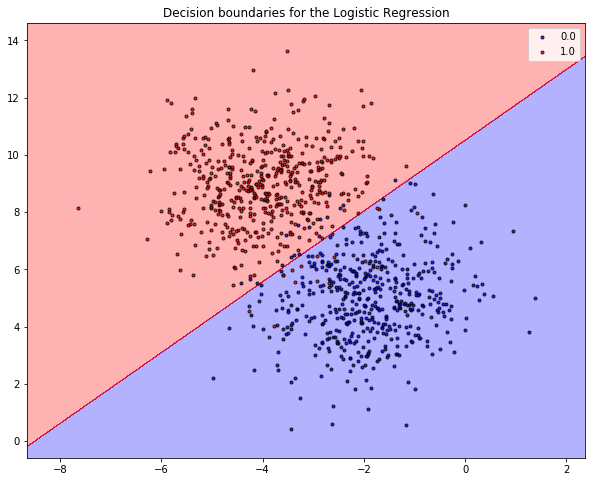

In [18]:
# plot the decision boundaries for the Logistic Regression model (using the training set)
plot_decision_regions(X_train_1000, y_train_1000, logistic_regression)
plt.title('Decision boundaries for the Logistic Regression')
plt.legend()
plt.show()

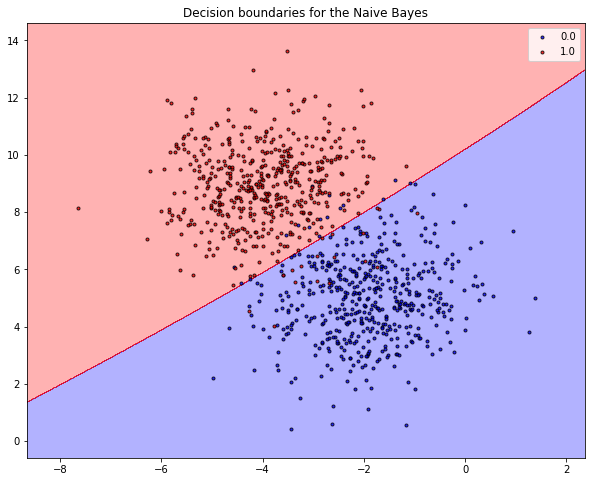

In [19]:
# plot the decision boundaries for the Naive Bayes model (using the training set)
plot_decision_regions(X_train_1000, y_train_1000, naive_bayes)
plt.title('Decision boundaries for the Naive Bayes')
plt.legend()
plt.show()

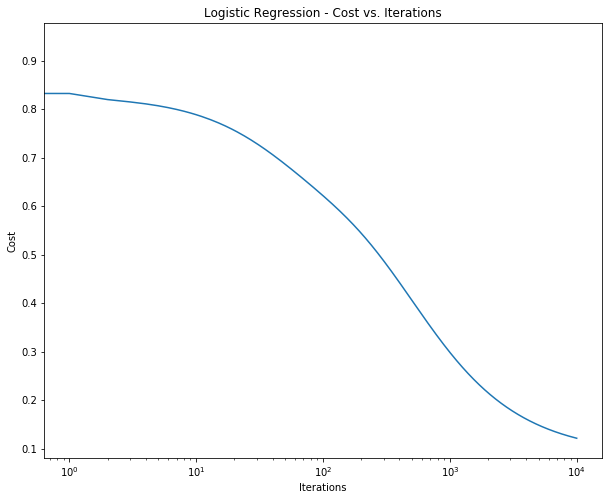

In [20]:
# plot the cost vs the iteration number for the Logistic Regression model
plt.plot(np.arange(min(logistic_regression.n_iter, len(logistic_regression.J_history))), logistic_regression.J_history)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Logistic Regression - Cost vs. Iterations')
plt.show()

### All the training and the test set points

In [21]:
# initial the datasets
training_set_vals = training_set.values
X_train_vals = training_set_vals[:, :-1]
y_train_vals = training_set_vals[:, -1]

test_set_vals = test_set.values
X_test_vals = test_set_vals[:, :-1]
y_test_vals = test_set_vals[:, -1]

In [30]:
# fir the models: logistic regression and naive bayes
logistic_regression = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_regression.fit(X_train_vals, y_train_vals)
naive_bayes = NaiveBayesGaussian(k=1)
naive_bayes.fit(X_train_vals, y_train_vals)

In [31]:
# compute accuracies
lr_train_accuracy = compute_accuracy(logistic_regression, training_set_vals)
lr_test_accuracy = compute_accuracy(logistic_regression, test_set_vals)
nb_train_accuracy = compute_accuracy(naive_bayes, training_set_vals)
nb_test_accuracy = compute_accuracy(naive_bayes, test_set_vals)

print(f'Logistic Regression: Train Accuracy = {lr_train_accuracy}')
print(f'Logistic Regression: Test Accuracy = {lr_test_accuracy}')
print(f'Naive Bayes: Train Accuracy = {nb_train_accuracy}')
print(f'Naive Bayes: Test Accuracy = {nb_test_accuracy}')

Logistic Regression: Train Accuracy = 0.796
Logistic Regression: Test Accuracy = 0.792
Naive Bayes: Train Accuracy = 0.8845
Naive Bayes: Test Accuracy = 0.873


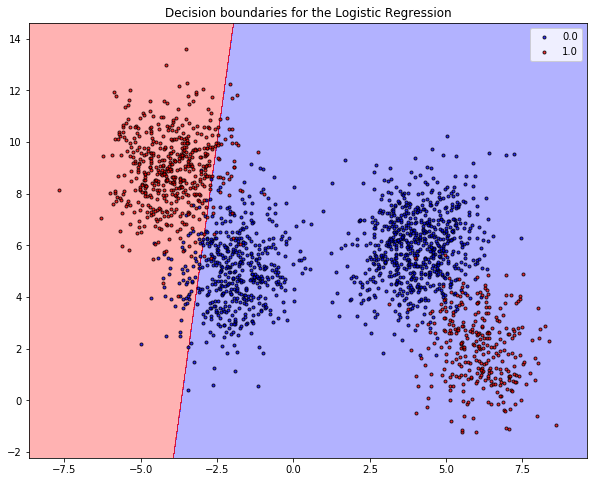

In [32]:
# plot the decision boundaries for the Logistic Regression model (using the training set)
plot_decision_regions(X_train_vals, y_train_vals, logistic_regression)
plt.title('Decision boundaries for the Logistic Regression')
plt.legend()
plt.show()

According to the graph above, we can observe that the logistic regression did not succeed to produce an accurate decision boundary since the data is not linearly separable.

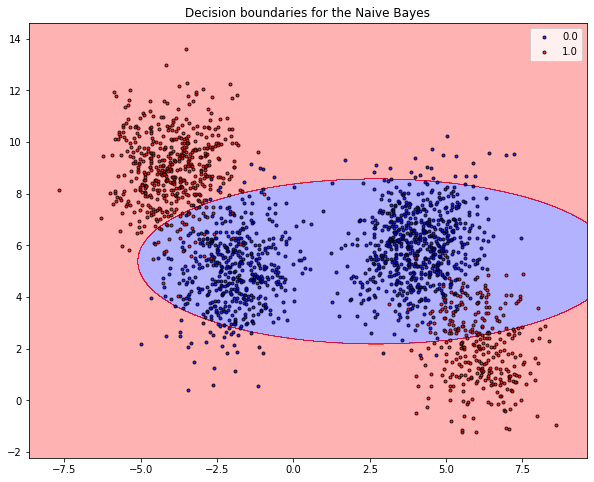

In [33]:
# plot the decision boundaries for the Naive Bayes model (using the training set)
plot_decision_regions(X_train_vals, y_train_vals, naive_bayes)
plt.title('Decision boundaries for the Naive Bayes')
plt.legend()
plt.show()

According to the graph above, we can see that even though we assumed that all the features are independent, we still received good results with the Naive Bayes model, and we can observe almost precise decision boundaries on the data.

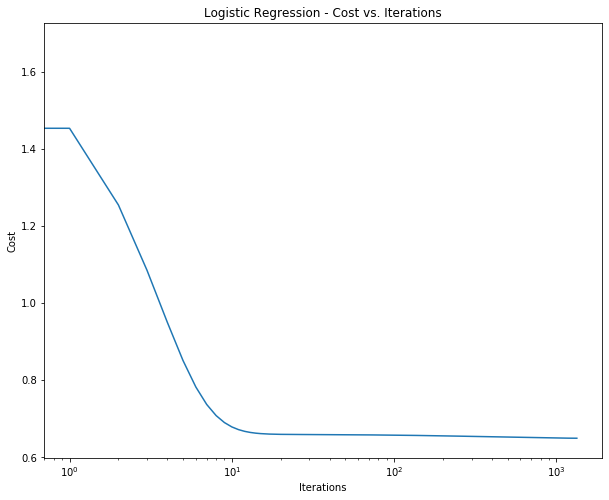

In [34]:
# plot the cost vs the iteration number for the Logistic Regression model
plt.plot(np.arange(min(logistic_regression.n_iter, len(logistic_regression.J_history))), logistic_regression.J_history)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Logistic Regression - Cost vs. Iterations')
plt.show()

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####


### Naive Bayes will work better than Logisitc Regression

In [35]:
######################################################
####### LOGISTIC REGRESSION VS. NAIVE BAYES ##########
################ NAIVE BAYES: BETTER #################
######################################################

size = [500, 500, 500]
means = [[10, -3], [2, -5], [-4, -5]]
cov = [[[1, 0.2], [0.2, 2]], [[1, 0], [0, 4]], [[1, 0], [0, 3]]]

# initial variables
x1, x2, y = [], [], []

# generate data points
for i in range(len(means)):
    _x1, _x2 = np.random.multivariate_normal(means[i], cov[i], size[i]).T
    x1.extend(_x1)
    x2.extend(_x2)
    y.extend([i % 2] * size[i])

# build the training data (X, y)
x1 = np.array(x1).reshape(-1, 1)
x2 = np.array(x2).reshape(-1, 1)
X = np.hstack((x1, x2))
y = np.array(y)
train_set_nb_better = np.hstack((X, y.reshape(-1, 1)))

# fit & compute accuracies of the models: Naive Bayes vs. Logistic Regression
nb = NaiveBayesGaussian(k=1)
lr = LogisticRegressionGD(eta=0.05, eps=1e-06)

nb.fit(X, y)
accuracy = compute_accuracy(nb, train_set_nb_better)
print(f'Naive Bayes Accuracy: {accuracy}')

lr.fit(X, y)
accuracy = compute_accuracy(lr, train_set_nb_better)

print(f'Logistic Regression Accuracy: {accuracy}')

Naive Bayes Accuracy: 0.962
Logistic Regression Accuracy: 0.6673333333333333


#### The logic behind the dataset above is that the data is not linearly separable. This way we can declare that Naive Bayes will perform better than Logistic Regression since it can build better boundary decisions.
-----

### Logistic Regression will work better than Naive Bayes using EM

In [36]:
######################################################
####### LOGISTIC REGRESSION VS. NAIVE BAYES ##########
########### LOGISTIC REGRESSION: BETTER ##############
######################################################

# set the multivariate normal initial parameters
size = [500, 500, 500]
means = [[2, -3], [2, -4], [-2, -5]]
cov = [[[1, 0.2], [0.2, 0.2]], [[1, 0.2], [0.2, 4]], [[3, 0.2], [0.2, 1]]]

# initial variables
x1, x2, y = [], [], []

# generate data points
for i in range(len(means)):
    _x1, _x2 = np.random.multivariate_normal(means[i], cov[i], size[i]).T
    x1.extend(_x1)
    x2.extend(_x2)
    y.extend([i % 2] * size[i])

# build the training data (X, y)
x1 = np.array(x1).reshape(-1, 1)
x2 = np.array(x2).reshape(-1, 1)
X = np.hstack((x1, x2))
y = np.array(y)
train_set_lr_better = np.hstack((X, y.reshape(-1, 1)))

# fit & compute accuracies of the models: Naive Bayes vs. Logistic Regression
nb = NaiveBayesGaussian(k=1)
lr = LogisticRegressionGD(eta=0.05, eps=1e-06)

nb.fit(X, y)
accuracy = compute_accuracy(nb, train_set_lr_better)
print(f'Naive Bayes Accuracy: {accuracy}')

lr.fit(X, y)
accuracy = compute_accuracy(lr, train_set_lr_better)
print(f'Logistic Regression Accuracy: {accuracy}')

Naive Bayes Accuracy: 0.6846666666666666
Logistic Regression Accuracy: 0.7333333333333333


#### The logic behind the dataset above is that almost half of the data, which contains different class values, are overlapped, and the other half which refers to only one class is separated from them. This way the Logistic Regression will find the boundary between the 2 massive classes, while Naive Bayes will opt to identify the overlapped data. An additional note, Naive Bayes assumes that the features are independent, which leads to inaccurate results when the features are indeed interdependent.
-----

# Visualization

### Naive Bayes will work better than Logisitc Regression

In [37]:
train_set_nb_better_0 = train_set_nb_better[train_set_nb_better[:, -1] == 0]
train_set_nb_better_1 = train_set_nb_better[train_set_nb_better[:, -1] == 1]
X_bn_better_set = train_set_nb_better[:, :-1]
y_bn_better_set = train_set_nb_better[:, -1]

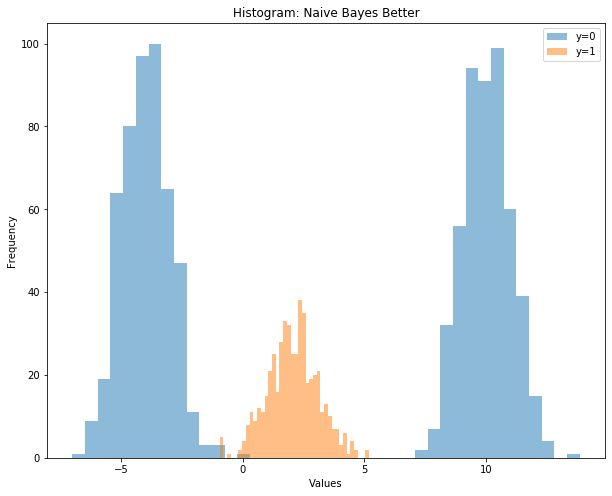

In [38]:
histogram_visualization(train_set_nb_better_0[:, 0], train_set_nb_better_1[:, 0],
              bins=40, alpha=0.5, title='Histogram: Naive Bayes Better')

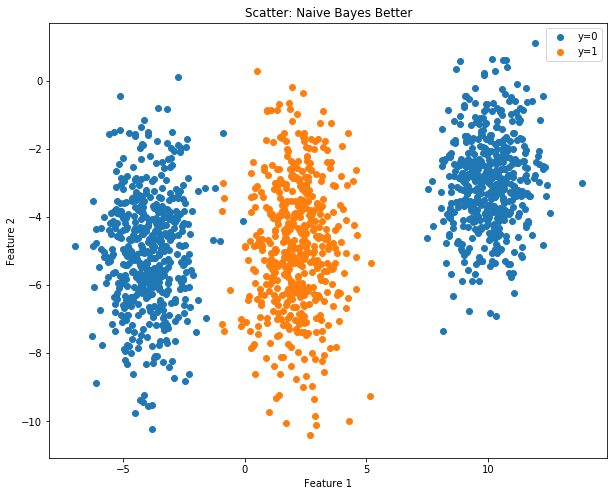

In [39]:
scatter_visualization(train_set_nb_better_0[:, :-1], train_set_nb_better_1[:, :-1],
                      title='Scatter: Naive Bayes Better')

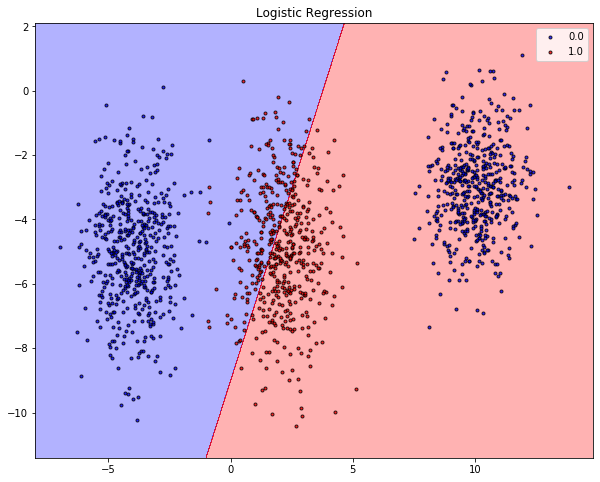

In [40]:
plot_decision_regions(X_bn_better_set, y_bn_better_set, lr)
plt.title('Logistic Regression')
plt.legend()
plt.show()

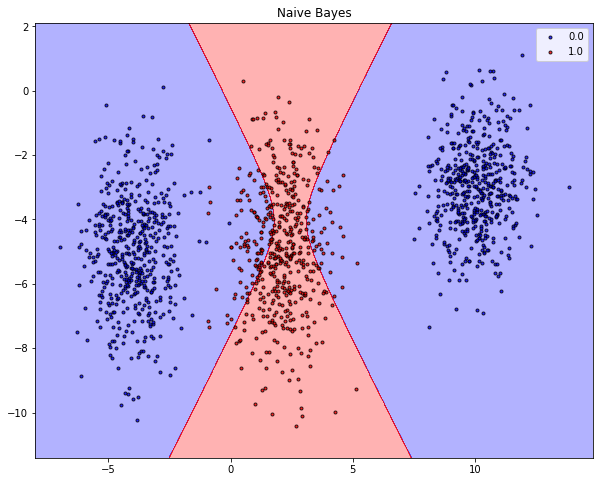

In [41]:
plot_decision_regions(X_bn_better_set, y_bn_better_set, nb)
plt.title('Naive Bayes')
plt.legend()
plt.show()

### Logistic Regression will work better than Naive Bayes using EM

In [42]:
train_set_lr_better_0 = train_set_lr_better[train_set_nb_better[:, -1] == 0]
train_set_lr_better_1 = train_set_lr_better[train_set_nb_better[:, -1] == 1]
X_lr_better_set = train_set_lr_better[:, :-1]
y_lr_better_set = train_set_lr_better[:, -1]

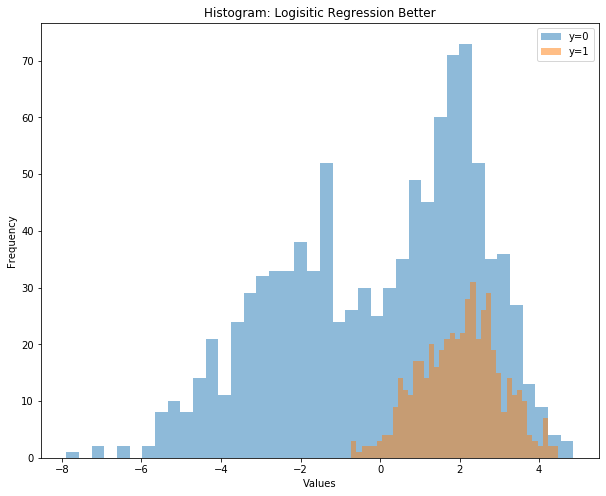

In [43]:
histogram_visualization(train_set_lr_better_0[:, 0], train_set_lr_better_1[:, 0],
              bins=40, alpha=0.5, title='Histogram: Logisitic Regression Better')

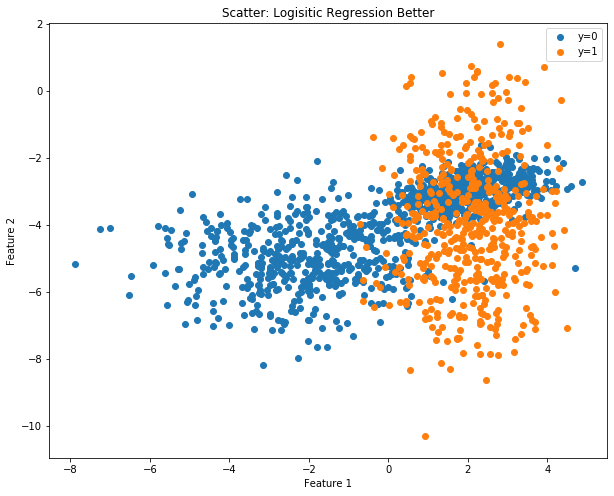

In [44]:
scatter_visualization(train_set_lr_better_0[:, :-1], train_set_lr_better_1[:, :-1],
                      title='Scatter: Logisitic Regression Better')

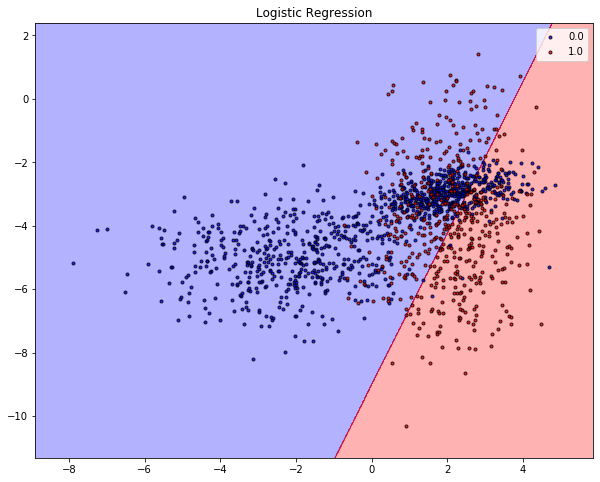

In [45]:
plot_decision_regions(X_lr_better_set, y_lr_better_set, lr)
plt.title('Logistic Regression')
plt.legend()
plt.show()

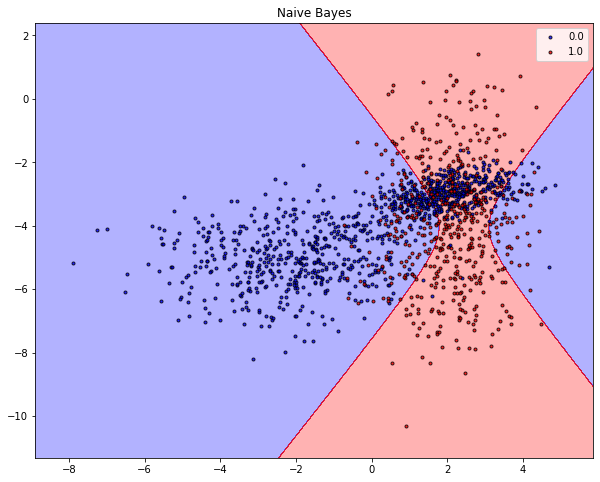

In [46]:
plot_decision_regions(X_lr_better_set, y_lr_better_set, nb)
plt.title('Naive Bayes')
plt.legend()
plt.show()